In [1]:
from ete3 import Tree
import networkx as nx 
import pandas as pd 
import numpy as np
from functools import reduce
from tqdm import tqdm_notebook
import pickle as pic 

from collections import OrderedDict, defaultdict

import scipy.stats as scs
import cassiopeia.TreeSolver.compute_meta_purity as cmp
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sys
import os 

from scipy.linalg import eig 
import matplotlib

import utilities.compute_transition_probs as ctp
import utilities.fitch_parsimony as fp
import utilities.sankoff_parsimony as sankoff_parsimony

from contextlib import suppress

from cassiopeia.TreeSolver.Node import Node
import itertools


In [24]:
def reconcile_fitch(T):
    
    source = [n for n in T if T.in_degree(n) == 0][0]
    for e in nx.dfs_edges(T):
        
        p, c = e[0], e[1]
        ns = np.intersect1d(T.nodes[p]['label'], T.nodes[c]['label']).tolist()
        
        if len(ns) > 0 and len(ns) == len(T.nodes[p]['label']):
            T.nodes[c]['label'] = ns 
        else:
            T.nodes[c]['label'] = list(T.nodes[c]['label'])
    return T

def count_opt_solutions(T, possible_assignments, node_to_i, label_to_j):
    
    def fill_DP(v, s):

        if t.out_degree(v) == 0:
            return 1
        
        children = list(T.successors(v))
        A = np.zeros((len(children)))
        
        for i, u in zip(range(len(children)), children):
            if s not in T.nodes[u]['label']:
                A[i] = 0
                for sp in T.nodes[u]['label']:
                    if L[node_to_i[u], label_to_j[sp]] == 0:
                        L[node_to_i[u], label_to_j[sp]] = fill_DP(u, sp)
                    A[i] += L[node_to_i[u], label_to_j[sp]]
            else:
                if L[node_to_i[u], label_to_j[s]] == 0:
                    L[node_to_i[u], label_to_j[s]] = fill_DP(u, s)
                A[i] = L[node_to_i[u], label_to_j[s]]
                
        return np.prod([A[u] for u in range(len(A))])
    
    L = np.full((len(T.nodes), len(possible_assignments)), 0)
    
    root = [n for n in T if T.in_degree(n) == 0][0]
    
    for s in T.nodes[root]['label']:
        L[node_to_i[root], label_to_j[s]] = fill_DP(root, s)
        
    return L

def count_num_transitions(T, L, possible_labels, node_to_i, label_to_j):
    
    def fill_transition_DP(v, s, s1, s2):
        
        if t.out_degree(v) == 0:
            return 0
        
        children = list(T.successors(v))
        A = np.zeros((len(children)))
        LS = [[]] * len(children)
        
        for i, u in zip(range(len(children)), children):
            LS_u = None
            if s in T.nodes[u]['label']:
                LS[i] = [s]
            else:
                LS[i] = T.nodes[u]['label']
            
            A[i] = 0
            for sp in LS[i]:
                #if C[node_to_i[u], label_to_j[sp], label_to_j[s1], label_to_j[s2]] == 0:
                    # C[node_to_i[u], label_to_j[sp], label_to_j[s1], label_to_j[s2]] = fill_transition_DP(u, sp, s1, s2)
                A[i] += C[node_to_i[u], label_to_j[sp], label_to_j[s1], label_to_j[s2]]
            
            if (s1 == s and s2 in LS[i]):
                A[i] += L[node_to_i[u], label_to_j[s2]]
            
            #if s1 == 'H' and s2 == 'G':
            #    print(A[i], u.name, s1, s2)

        parts = []
        for i, u in zip(range(len(children)), children):
            prod = 1
            
            for k, up in zip(range(len(children)), children):
                fact = 0
                if up == u:
                    continue
                for sp in LS[k]:
                    fact += L[node_to_i[up], label_to_j[sp]]
                
                prod *= fact 
                
            part = A[i] * prod
            parts.append(part)

        return np.sum(parts)
    
    C = np.zeros((len(T.nodes), L.shape[1], L.shape[1], L.shape[1]))
    root = [n for n in T if T.in_degree(n) == 0][0]

    for n in nx.dfs_postorder_nodes(T, source=root):
        for s in T.nodes[n]['label']:
            for s_pair in itertools.product(possible_labels, repeat=2):
                s1, s2 = s_pair[0], s_pair[1]
                C[node_to_i[n], label_to_j[s], label_to_j[s1], label_to_j[s2]] = fill_transition_DP(n, s, s1, s2)
                
    return C

def compute_transitions(t, meta):

    root = [n for n in t if t.in_degree(n) == 0][0]
    t = ctp.assign_labels(t, meta)
    possible_labels = meta.unique()

    t = cmp.set_depth(t, root)
    t = fp.fitch_bottom_up(t, root)

    bfs_postorder = [root]
    for e0, e1 in nx.bfs_edges(t, root):
        bfs_postorder.append(e1)

    node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
    label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

    t = reconcile_fitch(t)

    L = count_opt_solutions(t, possible_labels, node_to_i, label_to_j)

    C = count_num_transitions(t, L, possible_labels, node_to_i, label_to_j)

    count_mat = pd.DataFrame(np.zeros((L.shape[1], L.shape[1])))
    count_mat.columns = possible_labels
    count_mat.index = possible_labels 

    # count_mat: transitions are rows -> columns
    for s1 in possible_labels:
        for s2 in possible_labels:
            if s1 != s2:
                count_mat.loc[s1, s2] = np.sum(C[node_to_i[root], :, label_to_j[s1], label_to_j[s2]])

    return count_mat


In [61]:
def test1():
    
    t = nx.DiGraph()

    t.add_nodes_from([0, 1, 2,3 ,4 , 5, 6, 7, 8,9, 10, 11, 12])
    t.add_edges_from([(0, 1),(0,2), (1,3), (1,4), (2,5), (2,6), (3,7), (3,8), (5,9), (5,10), (6,11), (6,12)])
    rndict = {}
    for n in t.node:
        nn = Node(n, [])
        rndict[n] = nn
    t = nx.relabel_nodes(t, rndict)

    label_dict = {4: 'C', 7: 'A', 8: 'T', 9: 'A', 10: 'G', 11: 'T', 12: 'C'}

    meta = pd.DataFrame.from_dict(label_dict, orient='index')
    
    root = [n for n in t if t.in_degree(n) == 0][0]
    t = ctp.assign_labels(t, meta.iloc[:,0])
    possible_labels = meta.iloc[:,0].unique()

    t = cmp.set_depth(t, root)
    t = fp.fitch_bottom_up(t, root)

    bfs_postorder = [root]
    for e0, e1 in nx.bfs_edges(t, root):
        bfs_postorder.append(e1)

    node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
    label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

    t = reconcile_fitch(t)
    
    L = count_opt_solutions(t, possible_labels, node_to_i, label_to_j)
    
    mat = compute_transitions(t, meta.iloc[:,0])
    
    print(mat)
    
def test2():
    
    t = nx.balanced_tree(2,3, create_using=nx.DiGraph())
    
    rndict={}
    for n in t.node:
        nn = Node(n, [])
        rndict[n] = nn  

    t = nx.relabel_nodes(t, rndict)

    label_dict = {7: 'H', 8: 'G', 9: 'G', 10: 'M', 11: 'L', 12: 'M', 13: 'L', 14: 'M'}

    meta = pd.DataFrame.from_dict(label_dict, orient='index')

    root = [n for n in t if t.in_degree(n) == 0][0]
    t = ctp.assign_labels(t, meta.iloc[:,0])
    possible_labels = meta.iloc[:,0].unique()

    t = cmp.set_depth(t, root)
    t = fp.fitch_bottom_up(t, root)

    bfs_postorder = [root]
    for e0, e1 in nx.bfs_edges(t, root):
        bfs_postorder.append(e1)

    node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
    label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

    t = reconcile_fitch(t)

    L = count_opt_solutions(t, possible_labels, node_to_i, label_to_j)
    
    mat = compute_transitions(t, meta.iloc[:,0])
        
    print(mat)

In [62]:
test2()

NetworkXError: nbunch is not a node or a sequence of nodes.

In [65]:
t = nx.balanced_tree(2,3, create_using=nx.DiGraph())
    
rndict={}
for n in t.node:
    nn = Node(n, [])
    rndict[n] = nn  

t = nx.relabel_nodes(t, rndict)

label_dict = {7: 'H', 8: 'G', 9: 'G', 10: 'M', 11: 'L', 12: 'M', 13: 'L', 14: 'M'}

meta = pd.DataFrame.from_dict(label_dict, orient='index')

root = [n for n in t if t.in_degree(n) == 0][0]
t = ctp.assign_labels(t, meta.iloc[:,0])
possible_labels = meta.iloc[:,0].unique()

t = cmp.set_depth(t, root)
t = fp.fitch_bottom_up(t, root)

bfs_postorder = [root]
for e0, e1 in nx.bfs_edges(t, root):
    bfs_postorder.append(e1)
    
node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

t = reconcile_fitch(t)

    
L = count_opt_solutions(t, possible_labels, node_to_i, label_to_j)

compute_transitions(t, meta.iloc[:,0])

,H,G,M,L
H,0.0,0.0,0.0,0.0
G,4.0,0.0,5.0,1.0
M,0.0,1.0,0.0,4.0
L,0.0,1.0,4.0,0.0


In [9]:
t = ctp.assign_labels(t, meta.iloc[:,0])
possible_labels = meta.iloc[:,0].unique()

C = sankoff_parsimony.sankoff(t, possible_labels=possible_labels)
pars = np.amin(C[0,:])

root = [n for n in t if t.in_degree(n) == 0][0]
    
bfs_postorder = [root]
for e0, e1 in nx.bfs_edges(t, root):
    bfs_postorder.append(e1)

node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

opt_solutions_root = np.where(C[node_to_i[root], :] == pars)[0] 

tmat = np.zeros((C.shape[1], C.shape[1]))
for o in opt_solutions_root:
    sol, tm = count_opt_solutions_DP(t, C, root, o, node_to_i)
    tmat += tm 

tmat


TypeError: unhashable type: 'list'

In [5]:
tmat, semat = ctp.compute_transition_matrix(t, meta.iloc[:,0], iterations = 100, plot=False)
print(tmat)

       H       L     M
H    NaN  0.1675  0.29
L  0.315     NaN  0.21
M  0.000  0.0175   NaN


In [472]:
t = ctp.assign_labels(t, meta.iloc[:,0])
possible_labels = meta.iloc[:,0].unique()

C = sankoff_parsimony.sankoff(t, possible_labels=possible_labels)
# print(C)
pars = np.amin(C[0,:])

root = [n for n in t if t.in_degree(n) == 0][0]
    
bfs_postorder = [root]
for e0, e1 in nx.bfs_edges(t, root):
    bfs_postorder.append(e1)

node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

num_sol, t_mat = count_opt_solutions(t, C, root, node_to_i, t_mat = np.zeros((C.shape[1], C.shape[1])))
num_sol, t_mat
# print(num_sol)
# print(t_mat)
# print(t_mat / (pars * num_sol))

(5, array([[ 0.,  7., 10.],
        [ 1.,  0.,  1.],
        [ 0.,  0.,  0.]]))

## Read in lineage groups

In [2]:
lg_meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col = 0)

home_dir = '/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/'


lg_to_tree = {}
for tree_dir in os.listdir(home_dir):
    tree_dir = home_dir + tree_dir + "/"

    if not os.path.isdir(tree_dir):
        continue
    
    lg = tree_dir.split("/")[-2][2:]
    fps = [fp for fp in os.listdir(tree_dir) if ".processed.pkl" in fp and 'nj' not in fp]
    if len(fps) > 0:
        try:
            tree = nx.read_gpickle(tree_dir + fps[0])
            lg_to_tree[int(lg)] = tree
        except:
            # print(lg)
            continue

Text(0.5, 1.0, 'Consensus Estimated Transition Probabilities')

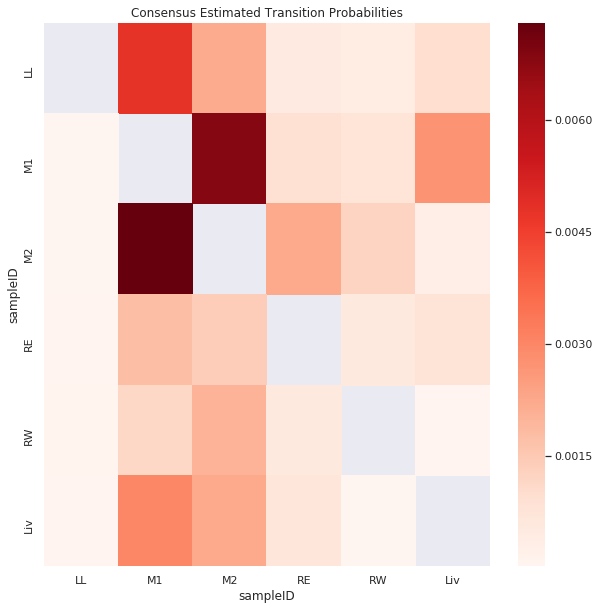

In [8]:
lg1 = lg_to_tree[19].get_network()
count_arr = ctp.compute_transitions(lg1, lg_meta['sampleID'])

# row_sums = count_arr.sum(axis=1)
# count_arr /= row_sums[:, np.newaxis]
count_arr /= np.sum(count_arr.values)
np.fill_diagonal(count_arr.values, np.nan)
cmap = matplotlib.cm.RdBu
cmap.set_bad("white", 1.)
h = plt.figure(figsize=(10, 10))
sns.heatmap(count_arr.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]], mask = np.fill_diagonal(np.zeros(count_arr.shape), 1), cmap="Reds")
plt.ylabel("sampleID")
plt.xlabel("sampleID")
plt.title("Consensus Estimated Transition Probabilities")

# lg1 = ctp.assign_labels(lg1,lg_meta['sampleID'])
# possible_labels = lg_meta['sampleID'].unique()

# C = sankoff_parsimony.sankoff(lg1, possible_labels=possible_labels)
# # print(C)
# pars = np.amin(C[0,:])
# print(pars)

# root = [n for n in lg1 if lg1.in_degree(n) == 0][0]
    
# bfs_postorder = [root]
# for e0, e1 in nx.bfs_edges(lg1, root):
#     bfs_postorder.append(e1)

# node_to_i = dict(zip(bfs_postorder, range(len(lg1.nodes))))
# label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

# num_sol, t_mat = count_opt_solutions(lg1, C, root, node_to_i, label_to_j, t_mat = np.zeros((C.shape[1], C.shape[1])))
# print(t_mat / (pars * num_sol))

           RW        RE        M2        M1       Liv        LL
RW        NaN  0.027272  0.041294  0.028543  0.004665  0.004469
RE   0.023105       NaN  0.061922  0.067168  0.018175  0.011922
M2   0.058221  0.065040       NaN  0.138697  0.023540  0.012656
M1   0.045858  0.047643  0.110262       NaN  0.025651  0.021585
Liv  0.008444  0.002984  0.012340  0.006606       NaN  0.003163
LL   0.019742  0.023241  0.039966  0.041023  0.004804       NaN


Text(0.5, 1.0, 'Random Background')

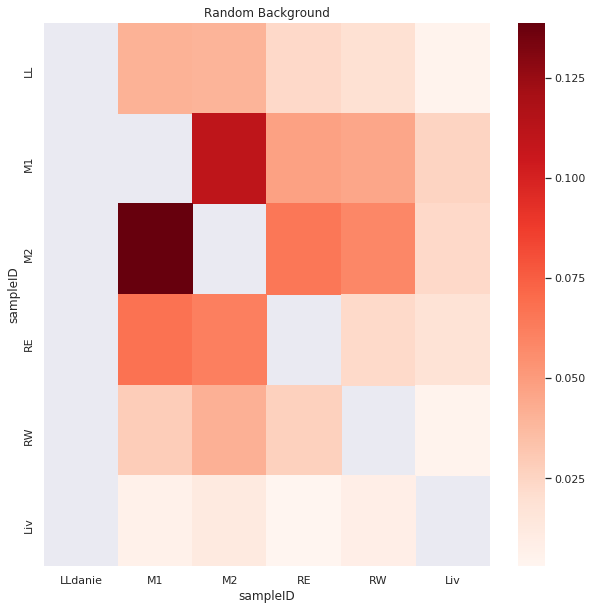

In [11]:
bg = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/transition_backgrounds/lg19_background_mat.txt", sep='\t', index_col = 0)
labels = bg.columns
np.fill_diagonal(bg.values, 0)
bg /= np.sum(bg.values)
np.fill_diagonal(bg.values, np.nan)
bg = pd.DataFrame(bg, index=labels, columns=labels)
print(bg)
cmap.set_bad("white", 1.)
h = plt.figure(figsize=(10, 10))
sns.heatmap(bg.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LLdanie', "M1", "M2", "RE", 'RW', "Liv"]], mask = np.fill_diagonal(np.zeros(bg.shape), 1), cmap="Reds")
plt.ylabel("sampleID")
plt.xlabel("sampleID")
plt.title("Random Background")

Text(0.5, 1.0, 'Consensus Estimated Transition Probabilities')

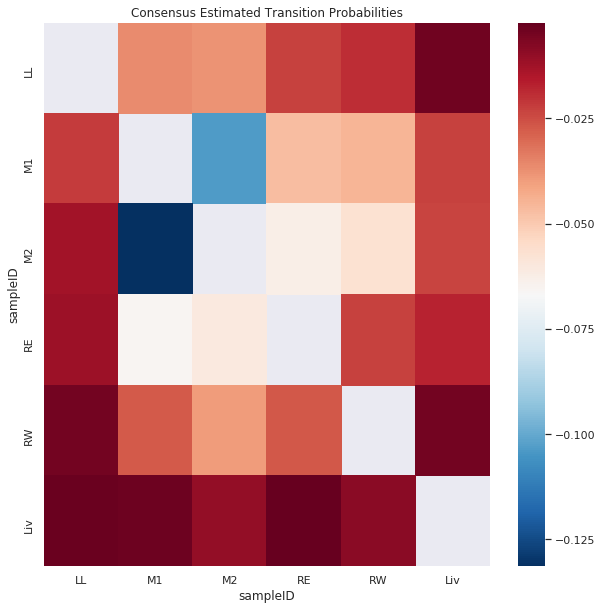

In [12]:
res = count_arr.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]] - bg.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]]

cmap = matplotlib.cm.RdBu
cmap.set_bad("white", 1.)
h = plt.figure(figsize=(10, 10))
sns.heatmap(res, mask = np.fill_diagonal(np.zeros(res.shape), 1), cmap="RdBu_r")
plt.ylabel("sampleID")
plt.xlabel("sampleID")
plt.title("Consensus Estimated Transition Probabilities")


## Form transition matrices

In [16]:
consensus_mat = ctp.build_consensus_transition_mat([tree.get_network() for tree in lg_to_tree.values()], lg_meta, 'sampleID', iterations=200)

100%|██████████| 99/99 [1:20:07<00:00, 48.56s/it]


In [17]:
consensus_mat.to_csv("consensus_transition_matrix.UNNORMALIZED.txt", sep='\t')
# consensus_mat = pd.read_csv("consensus_transition_matrix.UNNORMALIZED.txt", sep='\t', index_col = 0)

In [18]:
bg_dir = '/home/mattjones/projects/metastasis/JQ19/5k/transition_backgrounds/'
weights = {}

lgs = lg_to_tree.values()
total_size = np.sum([len(lg.network.nodes()) for lg in lgs])
num_lgs = len(lgs)
num_meta = len(lg_meta['sampleID'].unique())

for n in lg_to_tree.keys():
    weights[n] = len(lg_to_tree[n].network.nodes()) / total_size
    
bg_consensus = np.zeros((num_meta, num_meta))

for bgfp in os.listdir(bg_dir):
    
    bg = pd.read_csv(bg_dir + bgfp, sep='\t', index_col = 0)
    lg = bgfp.split("_")[0][2:]
    
    bg_consensus += bg * (weights[int(lg)] / num_lgs)

    labels = bg_consensus.columns
    bg_consensus = bg_consensus.values
    np.fill_diagonal(bg_consensus, np.nan)

    bg_consensus = pd.DataFrame(bg_consensus, index=labels, columns=labels)


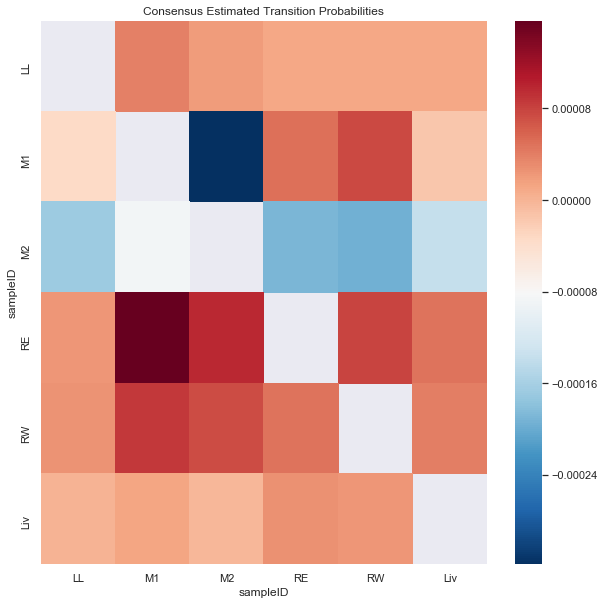

In [21]:
res = consensus_mat.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]] - bg_consensus.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]]

cmap = matplotlib.cm.RdBu
cmap.set_bad("white", 1.)
h = plt.figure(figsize=(10, 10))
sns.heatmap(res, mask = np.fill_diagonal(np.zeros(res.shape), 1), cmap="RdBu_r")
plt.ylabel("sampleID")
plt.xlabel("sampleID")
plt.title("Consensus Estimated Transition Probabilities")

plt.savefig('consensus_transition_matrix.NORMALIZED.pdf')